## Backpropagation
Now we go behind the scenes. So the ResNet34 pre-trained model was trained on ImageNet, which has 1000 classes. Thus, the penultimate layer is a matrix with 1000 columns, followed by an activation. However, when we do transfer learning, it's unlikely that our application will have 1000 classes, or even the *same* 1000 classes. So we throw away the last matrix, and we add two new matrices, separated by a ReLU activation.
![Fig 1](https://raw.githubusercontent.com/hiromis/notes/master/lesson5/2.png)
Now the first matrix has a default size, but the second matrix is the size you need. And this is governed by `data.c` that we used, where `data` is a `DataBunch` object.

So now we have our network, where these two matrices have random numbers. And these need to be trained. But while training, we only run backpropagation for these two layers, because the earlier layers are good at low-level details like edges, and we freeze them.

What happens when we use `unfreeze()`? It unfreezes the earlier layers, but it does one additional thing: the early layers detect low-level details, and these are unlikely to change across different applications. So we split up the layers into sections. So the later layers train at a higher learning rate, say $10^{-3}$, but the earlier layers use a smaller learning rate, like $10^{-5}$. This is called **discriminative learning rates**.

When we call fit, we can pass in one of three learning rate parameters in `fastai`:
* `1e-3`: When you pass in a single number, you don't use discriminative learning rates, and every layer uses the same value.
* `slice(1e-3)`: The final layers get an LR of `1e-3`, and the other layers get `1e-3/3`.
* `slice(1e-5, 1e-3)`: The first layers get `1e-5`, the last layers get `1e-3`, and the middle layers get learning rates multiplicatively spread out learning rates. For simplicity, only 3 layer groups are made--the last layers added are one group. The division by 3 is a specific quirk around batch normalization, and will be discussed in Part 2.

## Collaborative Filtering

In [0]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip

--2019-02-13 01:17:13--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.34.235
Connecting to files.grouplens.org (files.grouplens.org)|128.101.34.235|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  5.08MB/s    in 0.9s    

2019-02-13 01:17:15 (5.08 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [3]:
!unzip ml-100k.zip

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base         
  inflating: ml-100k/u2.test         
  inflating: ml-100k/u3.base         
  inflating: ml-100k/u3.test         
  inflating: ml-100k/u4.base         
  inflating: ml-100k/u4.test         
  inflating: ml-100k/u5.base         
  inflating: ml-100k/u5.test         
  inflating: ml-100k/ua.base         
  inflating: ml-100k/ua.test         
  inflating: ml-100k/ub.base         
  inflating: ml-100k/ub.test         


In [0]:
path = Path('ml-100k')

In [5]:
path.ls()

[PosixPath('ml-100k/u.info'),
 PosixPath('ml-100k/u.genre'),
 PosixPath('ml-100k/u2.test'),
 PosixPath('ml-100k/u5.test'),
 PosixPath('ml-100k/u4.test'),
 PosixPath('ml-100k/u5.base'),
 PosixPath('ml-100k/ub.test'),
 PosixPath('ml-100k/ua.test'),
 PosixPath('ml-100k/u.item'),
 PosixPath('ml-100k/allbut.pl'),
 PosixPath('ml-100k/u4.base'),
 PosixPath('ml-100k/mku.sh'),
 PosixPath('ml-100k/ua.base'),
 PosixPath('ml-100k/u3.base'),
 PosixPath('ml-100k/u3.test'),
 PosixPath('ml-100k/ub.base'),
 PosixPath('ml-100k/u.occupation'),
 PosixPath('ml-100k/u1.test'),
 PosixPath('ml-100k/README'),
 PosixPath('ml-100k/u2.base'),
 PosixPath('ml-100k/u.user'),
 PosixPath('ml-100k/u1.base'),
 PosixPath('ml-100k/u.data')]

In [0]:
ratings = pd.read_csv(path/'u.data', delimiter='\t', header=None, names=['userId', 'movieId', 'rating', 'timestamp'])

In [7]:
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [0]:
movies = pd.read_csv(path/'u.item', delimiter='|', encoding='latin-1', header=None, 
                     names=['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])

In [9]:
movies.head()

,movieId,title,date,N,url,g0,g1,g2,g3,g4,...,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [10]:
rating_movie = ratings.merge(movies[['movieId', 'title']])
rating_movie.head()

,userId,movieId,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


In [0]:
# By default, CollabDataBunch assumes the first column is user, second is item, but
# here we'll use the title for the item
data = CollabDataBunch.from_df(rating_movie, pct_val=0.1, item_name='title')

In [14]:
data.show_batch()

userId,title,target
424,"Birdcage, The (1996)",4.0
751,Speed (1994),3.0
146,Everyone Says I Love You (1996),4.0
916,Bullets Over Broadway (1994),3.0
919,Welcome to the Dollhouse (1995),5.0


In [0]:
y_range = [0,5.5]

In [0]:
learn = collab_learner(data, n_factors=40, y_range=y_range, wd=1e-1)

In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


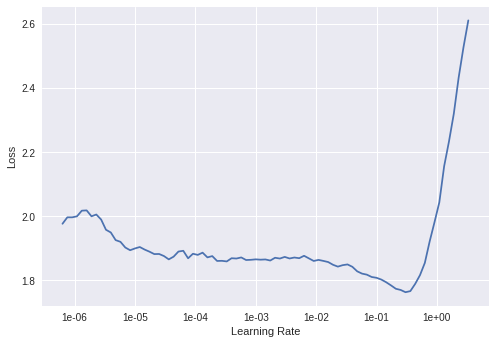

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss
1,0.970695,0.936915
2,0.892571,0.895870
3,0.782849,0.835693
4,0.637709,0.806661
5,0.474754,0.805712


The [LibRec library](https://www.librec.net/release/v1.3/example.html) published benchmarks, and their RMSE was 0.91, which corresponds to an MSE of 0.83.

In [0]:
learn.save('dotprod')

## Interpretation

In [21]:
learn.model

EmbeddingDotBias(
  (u_weight): Embedding(944, 40)
  (i_weight): Embedding(1652, 40)
  (u_bias): Embedding(944, 1)
  (i_bias): Embedding(1652, 1)
)

In [24]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]  # Most viewed movies

array(['Star Wars (1977)', 'Contact (1997)', 'Fargo (1996)', 'Return of the Jedi (1983)', 'Liar Liar (1997)',
       'English Patient, The (1996)', 'Scream (1996)', 'Toy Story (1995)', 'Air Force One (1997)',
       'Independence Day (ID4) (1996)'], dtype=object)

In [0]:
movie_bias = learn.bias(top_movies, is_item=True)

In [26]:
movie_bias.shape

torch.Size([1000])

In [0]:
mean_ratings = rating_movie.groupby('title')['rating'].mean()
movie_ratings = [(b, i, mean_ratings.loc[i]) for i,b in zip(top_movies,movie_bias)]

In [30]:
g = rating_movie.groupby('title')['rating'].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_movies[:10]

item0 = lambda o:o[0]
sorted(movie_ratings, key=item0, reverse=True)[:15]

[(tensor(0.7517), 'Shawshank Redemption, The (1994)', 4.445229681978798),
 (tensor(0.7419), 'Titanic (1997)', 4.2457142857142856),
 (tensor(0.7328), "Schindler's List (1993)", 4.466442953020135),
 (tensor(0.6941), 'Star Wars (1977)', 4.3584905660377355),
 (tensor(0.6931), 'Silence of the Lambs, The (1991)', 4.28974358974359),
 (tensor(0.6930), 'Casablanca (1942)', 4.45679012345679),
 (tensor(0.6522), 'Rear Window (1954)', 4.3875598086124405),
 (tensor(0.6478), 'Usual Suspects, The (1995)', 4.385767790262173),
 (tensor(0.6459), 'As Good As It Gets (1997)', 4.196428571428571),
 (tensor(0.6416), 'Good Will Hunting (1997)', 4.262626262626263),
 (tensor(0.6400),
  'Wallace & Gromit: The Best of Aardman Animation (1996)',
  4.447761194029851),
 (tensor(0.6362), 'L.A. Confidential (1997)', 4.161616161616162),
 (tensor(0.6110), 'Godfather, The (1972)', 4.283292978208232),
 (tensor(0.5953), 'Wrong Trousers, The (1993)', 4.466101694915254),
 (tensor(0.5731), 'Apt Pupil (1998)', 4.1)]

### Movie Weights

In [31]:
movie_w = learn.weight(top_movies, is_item=True)
movie_w.shape

torch.Size([1000, 40])

In [32]:
movie_pca = movie_w.pca(3)
movie_pca.shape

torch.Size([1000, 3])

In [0]:
fac0,fac1,fac2 = movie_pca.t()
movie_comp = [(f, i) for f,i in zip(fac0, top_movies)]

In [34]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1414), 'Jungle2Jungle (1997)'),
 (tensor(1.0989), 'Home Alone 3 (1997)'),
 (tensor(1.0479), 'Batman & Robin (1997)'),
 (tensor(0.9789), 'Leave It to Beaver (1997)'),
 (tensor(0.9246), 'Shadow Conspiracy (1997)'),
 (tensor(0.9047), 'Congo (1995)'),
 (tensor(0.8877), 'That Darn Cat! (1997)'),
 (tensor(0.8743), 'Vegas Vacation (1997)'),
 (tensor(0.8724), 'Batman Forever (1995)'),
 (tensor(0.8722), "McHale's Navy (1997)")]

In [35]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(tensor(-1.0631), 'Chinatown (1974)'),
 (tensor(-0.9903), 'Lawrence of Arabia (1962)'),
 (tensor(-0.9696), 'Citizen Kane (1941)'),
 (tensor(-0.9617), 'Secrets & Lies (1996)'),
 (tensor(-0.9346), '12 Angry Men (1957)'),
 (tensor(-0.9186), 'Wrong Trousers, The (1993)'),
 (tensor(-0.9180), 'Close Shave, A (1995)'),
 (tensor(-0.9073), 'Godfather, The (1972)'),
 (tensor(-0.9004), 'Ran (1985)'),
 (tensor(-0.8989), 'Apocalypse Now (1979)')]

In [36]:
movie_comp = [(f, i) for f,i in zip(fac1, top_movies)]
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(tensor(1.1245), 'Braveheart (1995)'),
 (tensor(0.9680), 'Raiders of the Lost Ark (1981)'),
 (tensor(0.9327), 'Forrest Gump (1994)'),
 (tensor(0.8809), 'Titanic (1997)'),
 (tensor(0.8698), 'Field of Dreams (1989)'),
 (tensor(0.8516), 'American President, The (1995)'),
 (tensor(0.8407), 'Pretty Woman (1990)'),
 (tensor(0.8313), "It's a Wonderful Life (1946)"),
 (tensor(0.8297), "Mr. Holland's Opus (1995)"),
 (tensor(0.8214), 'Affair to Remember, An (1957)')]

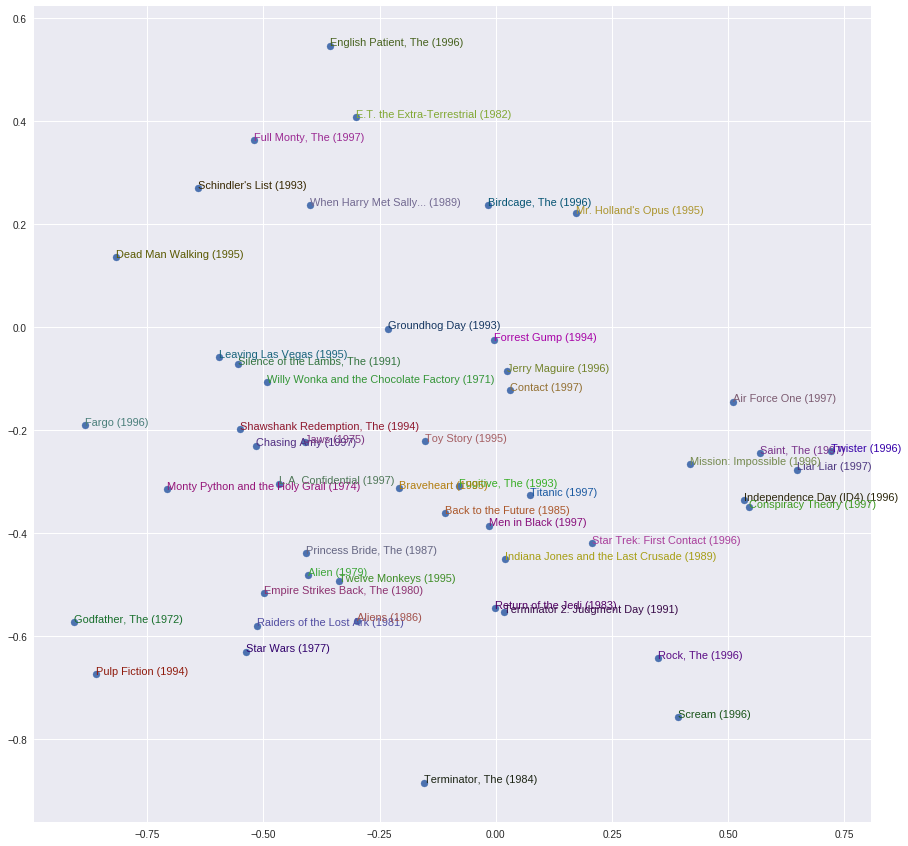

In [38]:
idxs = np.random.choice(len(top_movies), 50, replace=False)
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x,y,i, color=np.random.rand(3)*0.7, fontsize=11)
plt.show()